# Inaugural Project

> **Note the following:** 
> 1. This is an example of how to structure your **inaugural project**.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `inauguralproject.py` file includes a function which can be used multiple times in this notebook.

## 0. Imports and set magics:

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize

plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

# autoreload modules when code is run. Otherwise, python will not see recent changes. 
%load_ext autoreload
%autoreload 2

# Import your own code
import inauguralproject

## 1. Illustrating the Edgeworth Box

Explanation

In [6]:
from types import SimpleNamespace

class ExchangeEconomyClass:
    def __init__(self):
        par = self.par = SimpleNamespace()

        # a. preferences
        par.alpha = 1/3
        par.beta = 2/3

        # b. endowments
        par.w1A = 0.8
        par.w2A = 0.3
        par.w1B = 1 - par.w1A
        par.w2B = 1 - par.w2A

    def utility_A(self,x1A,x2A):
        return x1A ** self.par.alpha * x2A ** (1 - self.par.alpha)

    def utility_B(self,x1B,x2B):
        return x1B ** self.par.beta * x2B ** (1 - self.par.beta)

    def demand_A(self,p1):
        p2 = 1
        demand_x1A = self.par.alpha * ((p1 * self.par.w1A + p2 * self.par.w2A) / p1)
        demand_x2A = (1 - self.par.alpha) * ((p1 * self.par.w1A + p2 * self.par.w2A) / p1)
        return demand_x1A, demand_x2A

    def demand_B(self,p1):
        p2 = 1
        demand_x1B = self.par.beta * ((p1 * self.par.w1B + p2 * self.par.w2B) / p1)
        demand_x2B = (1 - self.par.beta) * ((p1 * self.par.w1B + p2 * self.par.w2B) / p1)
        return demand_x1B, demand_x2B

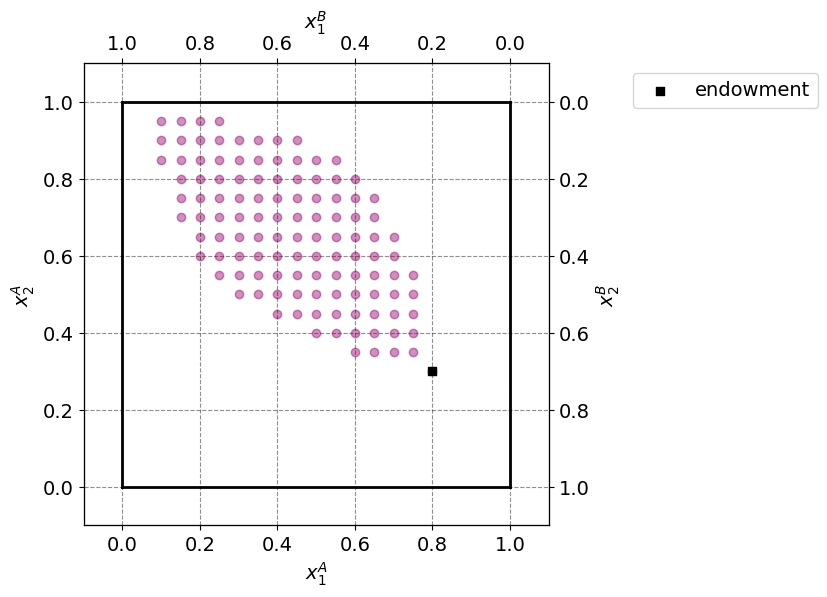

In [7]:
def check_edgeworth_box_vectorized(exchange_economy, N=20):
    par = exchange_economy.par
    grid = np.linspace(0, 1, N+1)

    x1A_grid, x2A_grid, x1B_grid, x2B_grid = np.meshgrid(grid, grid, grid, grid, indexing='ij')
    utility_A_grid = exchange_economy.utility_A(x1A_grid, x2A_grid)
    utility_B_grid = exchange_economy.utility_B(x1B_grid, x2B_grid)

    utility_A_endowment = exchange_economy.utility_A(par.w1A, par.w2A)
    utility_B_endowment = exchange_economy.utility_B(par.w1B, par.w2B)

    feasible_mask = (utility_A_grid >= utility_A_endowment) & (utility_B_grid >= utility_B_endowment)

    x1A_vals = x1A_grid[feasible_mask]
    x2A_vals = x2A_grid[feasible_mask]
    x1B_vals = x1B_grid[feasible_mask]
    x2B_vals = x2B_grid[feasible_mask]

    # Total endowment
    w1bar = 1.0
    w2bar = 1.0

    # b. figure set up
    fig = plt.figure(frameon=False,figsize=(6,6), dpi=100)
    ax_A = fig.add_subplot(1, 1, 1)

    ax_A.set_xlabel("$x_1^A$")
    ax_A.set_ylabel("$x_2^A$")

    temp = ax_A.twinx()
    temp.set_ylabel("$x_2^B$")
    ax_B = temp.twiny()
    ax_B.set_xlabel("$x_1^B$")
    ax_B.invert_xaxis()
    ax_B.invert_yaxis()

    # Plot scenarios where market clearing condition is satisfied
    for i in range(len(x1A_vals)):
        total_x1A = x1A_vals[i] + x1B_vals[i]
        total_x2A = x2A_vals[i] + x2B_vals[i]
        if np.isclose(total_x1A, par.w1A + par.w1B) and np.isclose(total_x2A, par.w2A + par.w2B):
            ax_A.scatter(x1A_vals[i], x2A_vals[i], marker='o', color='blue', alpha=0.25)
            ax_B.scatter(x1B_vals[i], x2B_vals[i], marker='o', color='red', alpha=0.25)

    plt.scatter(par.w1B,par.w2B,marker='s',color='black',label='endowment')

    # limits
    ax_A.plot([0,w1bar],[0,0],lw=2,color='black')
    ax_A.plot([0,w1bar],[w2bar,w2bar],lw=2,color='black')
    ax_A.plot([0,0],[0,w2bar],lw=2,color='black')
    ax_A.plot([w1bar,w1bar],[0,w2bar],lw=2,color='black')

    ax_A.set_xlim([-0.1, w1bar + 0.1])
    ax_A.set_ylim([-0.1, w2bar + 0.1])    
    ax_B.set_xlim([w1bar + 0.1, -0.1])
    ax_B.set_ylim([w2bar + 0.1, -0.1])

    plt.legend(frameon=True,loc='upper right',bbox_to_anchor=(1.6,1.0));

# Create an instance of ExchangeEconomyClass
exchange_economy = ExchangeEconomyClass()

# Check for feasible allocations within the Edgeworth box
check_edgeworth_box_vectorized(exchange_economy)

## 2. Calculating the error in the market clearing condition

Explanation

In [9]:
def calculate_market_error(exchange_economy, price_range):
    market_errors = []

    for p1 in price_range:
        p2 = 1.0  # Assuming constant prices for both goods
        demand_x1A, demand_x2A = exchange_economy.demand_A(p1)
        demand_x1B, demand_x2B = exchange_economy.demand_B(p1)

        # Calculate the total demand for each good
        total_demand_x1 = demand_x1A + demand_x1B
        total_demand_x2 = demand_x2A + demand_x2B

        # Calculate the market errors for each good
        error_x1 = abs(total_demand_x1 - (exchange_economy.par.w1A + exchange_economy.par.w1B))
        error_x2 = abs(total_demand_x2 - (exchange_economy.par.w2A + exchange_economy.par.w2B))

        # Append the market errors to the list
        market_errors.append((p1, error_x1, error_x2))

    return market_errors

# Create an instance of ExchangeEconomyClass
exchange_economy = ExchangeEconomyClass()

# Define the range of prices with specified increments
price_range = []
N = 75
increment = 2.0 / N
for i in range(N + 1):
    price_range.append(0.5 + i * increment)

# Calculate the market errors for the given price range
market_errors = calculate_market_error(exchange_economy, price_range)

# Convert the list of tuples to a pandas DataFrame
df = pd.DataFrame(market_errors, columns=['Price', 'Error_x1', 'Error_x2'])

# Display the DataFrame
print(df)

       Price  Error_x1  Error_x2
0   0.500000  0.533333  0.466667
1   0.526667  0.475949  0.422785
2   0.553333  0.424096  0.383133
3   0.580000  0.377011  0.347126
4   0.606667  0.334066  0.314286
..       ...       ...       ...
71  2.393333  0.363231  0.218942
72  2.420000  0.365840  0.220937
73  2.446667  0.368392  0.222888
74  2.473333  0.370889  0.224798
75  2.500000  0.373333  0.226667

[76 rows x 3 columns]


## 3. Calculating the market clearing price

Explain your code and procedure

In [13]:
def find_market_clearing_price(exchange_economy, price_range):
    min_error = float('inf')  # Initialize minimum error to positive infinity
    min_error_price = None  # Initialize the price corresponding to minimum error

    for p1 in price_range:
        p2 = 1.0
        demand_x1A, demand_x2A = exchange_economy.demand_A(p1)
        demand_x1B, demand_x2B = exchange_economy.demand_B(p1)

        # Calculate the total demand for each good
        total_demand_x1 = demand_x1A + demand_x1B
        total_demand_x2 = demand_x2A + demand_x2B

        # Calculate the market errors for each good
        error_x1 = abs(total_demand_x1 - (exchange_economy.par.w1A + exchange_economy.par.w1B))
        error_x2 = abs(total_demand_x2 - (exchange_economy.par.w2A + exchange_economy.par.w2B))

        # Calculate the total error
        total_error = error_x1 + error_x2

        # Update minimum error and corresponding price if the total error is less than the current minimum error
        if total_error < min_error:
            min_error = total_error
            min_error_price = p1
            opt_demand_x1A = demand_x1A
            opt_demand_x2A = demand_x2A
            opt_demand_x1B = demand_x1B
            opt_demand_x2B = demand_x2B

    return min_error_price, min_error, opt_demand_x1A, opt_demand_x2A, opt_demand_x1B, opt_demand_x2B

# Create an instance of ExchangeEconomyClass
exchange_economy = ExchangeEconomyClass()

# Define the range of prices
price_range = np.linspace(0, 2.5, 1000)

# Find the market-clearing price and minimum error
market_clearing_price, min_error, opt_demand_x1A, opt_demand_x2A, opt_demand_x1B, opt_demand_x2B = find_market_clearing_price(exchange_economy, price_range)

# Display the market-clearing price and minimum error
if market_clearing_price is not None:
    print("Market-clearing price:", market_clearing_price)
    print("Minimum error:", min_error)
    print("x1A", opt_demand_x1A)
    print("x2A", opt_demand_x2A)
    print("x1B", opt_demand_x1B)
    print("x2B", opt_demand_x2B)
else:
    print("Market-clearing price not found in the given price range.")


Market-clearing price: 0.9459459459459459
Minimum error: 0.05904761904761924
x1A 0.37238095238095237
x2A 0.7447619047619048
x1B 0.6266666666666666
x2B 0.31333333333333335


C:\Users\phili\AppData\Local\Temp\ipykernel_21692\3882795442.py:25: RuntimeWarning: divide by zero encountered in scalar divide
  demand_x1A = self.par.alpha * ((p1 * self.par.w1A + p2 * self.par.w2A) / p1)
C:\Users\phili\AppData\Local\Temp\ipykernel_21692\3882795442.py:26: RuntimeWarning: divide by zero encountered in scalar divide
  demand_x2A = (1 - self.par.alpha) * ((p1 * self.par.w1A + p2 * self.par.w2A) / p1)
C:\Users\phili\AppData\Local\Temp\ipykernel_21692\3882795442.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  demand_x1B = self.par.beta * ((p1 * self.par.w1B + p2 * self.par.w2B) / p1)
C:\Users\phili\AppData\Local\Temp\ipykernel_21692\3882795442.py:32: RuntimeWarning: divide by zero encountered in scalar divide
  demand_x2B = (1 - self.par.beta) * ((p1 * self.par.w1B + p2 * self.par.w2B) / p1)


## 4a. Allocation for P1

In [6]:
def maximize_utility_A(exchange_economy):
    par = exchange_economy.par

    # Define the utility function for agent A
    def utility_A(x1A, x2A):
        return exchange_economy.utility_A(x1A, x2A)

    # Define the objective function to maximize agent A's utility
    def objective_function(p1):
        demand_x1A, demand_x2A = exchange_economy.demand_A(p1)
        return -utility_A(demand_x1A, demand_x2A)

    # Find the price that maximizes agent A's utility
    result = minimize_scalar(objective_function, bounds=(0.5, 2.5))

    # Get the optimal price
    optimal_price = result.x

    # Get the allocation for agent A at the optimal price
    demand_x1A, demand_x2A = exchange_economy.demand_A(optimal_price)
    optimal_allocation_A = (demand_x1A, demand_x2A)

    return optimal_price, optimal_allocation_A

# Create an instance of ExchangeEconomyClass
exchange_economy = ExchangeEconomyClass()

# Find the price that maximizes agent A's utility and the corresponding allocation for agent A
optimal_price, optimal_allocation_A = maximize_utility_A(exchange_economy)

# Print the results
print("Optimal Price that Maximizes Utility for Agent A:", optimal_price)
print("Optimal Allocation for Agent A at this Price:", optimal_allocation_A)


Optimal Price that Maximizes Utility for Agent A: 0.5000040272797426
Optimal Allocation for Agent A at this Price: (0.46666505576774475, 0.9333301115354896)


Explain your code and procedure

## 4b. Allocation without price constraints

In [7]:
def maximize_utility_A(exchange_economy):
    par = exchange_economy.par

    # Define the utility function for agent A
    def utility_A(x1A, x2A):
        return exchange_economy.utility_A(x1A, x2A)

    # Define the objective function to maximize agent A's utility
    def objective_function(p1):
        demand_x1A, demand_x2A = exchange_economy.demand_A(p1)
        return -utility_A(demand_x1A, demand_x2A)

    # Find the price that maximizes agent A's utility
    result = minimize_scalar(objective_function, bounds=(0, 1000)) # Setting arbitrary high price as upper bound (1000)

    # Get the optimal price
    optimal_price = result.x

    # Get the allocation for agent A at the optimal price
    demand_x1A, demand_x2A = exchange_economy.demand_A(optimal_price)
    optimal_allocation_A = (demand_x1A, demand_x2A)

    return optimal_price, optimal_allocation_A

# Create an instance of ExchangeEconomyClass
exchange_economy = ExchangeEconomyClass()

# Find the price that maximizes agent A's utility and the corresponding allocation for agent A
optimal_price, optimal_allocation_A = maximize_utility_A(exchange_economy)

# Print the results
print("Optimal Price that Maximizes Utility for Agent A:", optimal_price)
print("Optimal Allocation for Agent A at this Price:", optimal_allocation_A)


Optimal Price that Maximizes Utility for Agent A: 3.737685985848595e-06
Optimal Allocation for Agent A at this Price: (26754.78814830372, 53509.57629660745)


ADD CONCISE CONLUSION.

## 5a. Allocation with choice set restricted to C

In [8]:
def maximize_utility_A(exchange_economy):
    par = exchange_economy.par

    # Initialize variables to store the best utility and corresponding allocation for A
    best_utility_A = -float('inf')
    best_allocation_A = None

    N = 75
    C = [(i/N, j/N) for i in range(N+1) for j in range(N+1)]    

    # Iterate over combinations in C
    for x1A, x2A in C:
        # Calculate utility for A
        utility_A = exchange_economy.utility_A(x1A, x2A)
        
        # Calculate utility for B
        x1B = 1 - x1A
        x2B = 1 - x2A
        utility_B = exchange_economy.utility_B(x1B, x2B)
        
        # Check if B's utility is not worse than initial endowment
        initial_utility_B = exchange_economy.utility_B(par.w1B, par.w2B)
        if not isinstance(utility_B, complex) and utility_B.real >= initial_utility_B:
            # Update best utility and allocation for A
            if utility_A > best_utility_A:
                best_utility_A = utility_A
                best_allocation_A = (x1A, x2A)

    return best_utility_A, best_allocation_A

# Create an instance of ExchangeEconomyClass
exchange_economy = ExchangeEconomyClass()

# Find the price that maximizes agent A's utility and the corresponding allocation for agent A
best_utility_A, best_allocation_A = maximize_utility_A(exchange_economy)

# Print the result
print("Best Allocation for A:", best_allocation_A)
print("Best Utility for A:", best_utility_A)


Best Allocation for A: (0.56, 0.8533333333333334)
Best Utility for A: 0.7415523509091093


## 5b. Allocation without restrictions

In [9]:
def maximize_utility_A(exchange_economy):
    par = exchange_economy.par

    def objective_function(x):
        # Calculate utility for agent A
        x1A, x2A = x
        return -exchange_economy.utility_A(x1A, x2A)  # Minimize negative utility

    def constraint_B(x):
        x1B = 1 - x[0]
        x2B = 1 - x[1]
        # Calculate utility for agent B
        return exchange_economy.utility_B(x1B, x2B) - exchange_economy.utility_B(par.w1B, par.w2B)  # Ensure B is not worse off

    # Initial guess
    x0 = [0.5, 0.5]  # Initial guess for x1 and x2

    # Define bounds for x1 and x2
    bounds = [(0, 1), (0, 1)]  # Bounds for x1 and x2

    # Define the constraint
    constraint = {'type': 'ineq', 'fun': constraint_B}

    # Perform optimization
    result = minimize(objective_function, x0, bounds=bounds, constraints=constraint)

    # Get the optimal allocation for agent A
    optimal_allocation_A = result.x

    # Calculate the utility for agent A
    optimal_utility_A = -result.fun  # Minimize negative utility, so take the negative of the objective function value

    return optimal_allocation_A, optimal_utility_A

# Create an instance of ExchangeEconomyClass
exchange_economy = ExchangeEconomyClass()

# Find the price that maximizes agent A's utility and the corresponding allocation for agent A
optimal_utility_A, optimal_allocation_A = maximize_utility_A(exchange_economy)

print("Optimal Allocation for A:", optimal_allocation_A)
print("Optimal Utility for A:", optimal_utility_A)


Optimal Allocation for A: 0.7100258610697728
Optimal Utility for A: [0.68087076 0.72506828]


## 6a. Allocation without restrictions

In [4]:
# Define the objective function to maximize the total utility
def objective_function(x, exchange_economy):
    x1A, x2A = x
    # Calculate utility for agent A
    uA = exchange_economy.utility_A(x1A, x2A)

    # Calculate utility for agent B
    x1B = 1 - x1A
    x2B = 1 - x2A
    uB = exchange_economy.utility_B(x1B, x2B)

    # Calculate total utility
    return -(uA + uB)  # Minimize negative total utility

# Create an instance of ExchangeEconomyClass
exchange_economy = ExchangeEconomyClass()

# Initial guess
x0 = [0.5, 0.5]  # Initial guess for x1A and x2A

# Define bounds for x1A and x2A
bounds = [(0, 1), (0, 1)]  # Bounds for x1A and x2A

# Perform optimization
result = minimize(objective_function, x0, args=(exchange_economy,), bounds=bounds)

# Get the optimal allocation for goods x1A and x2A
optimal_allocation_x1A, optimal_allocation_x2A = result.x

# Calculate the total utility
optimal_total_utility = -(result.fun)  # Minimize negative total utility, so take the negative of the objective function value

print("Optimal Allocation for x1A:", optimal_allocation_x1A)
print("Optimal Allocation for x2A:", optimal_allocation_x2A)
print("Optimal Total Utility:", optimal_total_utility)

Optimal Allocation for x1A: 0.3333333659693852
Optimal Allocation for x2A: 0.6666666260640767
Optimal Total Utility: 1.0582673679787966
